In [1]:
import SimpleITK as sitk
from platipy.imaging import ImageVisualiser
from platipy.imaging.registration.linear import linear_registration, alignment_registration
from platipy.imaging.registration.utils import apply_transform
from pathlib import Path
import glob
import numpy as np

In [2]:
img_ct_lung_5 = sitk.ReadImage("./PRHGD5257_LUNG/IMAGES/PRHGD5257_LUNG_0_CT_NON_CONTRAST_CHEST_5.nii.gz")
img_ct_lung_10 = sitk.ReadImage("./PRHGD5257_LUNG/IMAGES/PRHGD5257_LUNG_1_CT_NON_CONTRAST_CHEST_10.nii.gz")

Utility functions

In [3]:
def point2str(point, precision=1):
    """
    Format a point for printing, based on specified precision with trailing zeros. Uniform printing for vector-like data 
    (tuple, numpy array, list).
    
    Args:
        point (vector-like): nD point with floating point coordinates.
        precision (int): Number of digits after the decimal point.
    Return:
        String represntation of the given point "xx.xxx yy.yyy zz.zzz...".
    """
    return ' '.join(f'{c:.{precision}f}' for c in point)


def uniform_random_points(bounds, num_points):
    """
    Generate random (uniform withing bounds) nD point cloud. Dimension is based on the number of pairs in the bounds input.
    
    Args:
        bounds (list(tuple-like)): list where each tuple defines the coordinate bounds.
        num_points (int): number of points to generate.
    
    Returns:
        list containing num_points numpy arrays whose coordinates are within the given bounds.
    """
    internal_bounds = [sorted(b) for b in bounds]
         # Generate rows for each of the coordinates according to the given bounds, stack into an array, 
         # and split into a list of points.
    mat = np.vstack([np.random.uniform(b[0], b[1], num_points) for b in internal_bounds])
    return list(mat[:len(bounds)].T)


def target_registration_errors(tx, point_list, reference_point_list):
    """
    Distances between points transformed by the given transformation and their
    location in another coordinate system. When the points are only used to evaluate
    registration accuracy (not used in the registration) this is the target registration
    error (TRE).
    """
    return [np.linalg.norm(np.array(tx.TransformPoint(p)) -  np.array(p_ref))
          for p,p_ref in zip(point_list, reference_point_list)]


def print_transformation_differences(tx1, tx2):
    """
    Check whether two transformations are "equivalent" in an arbitrary spatial region 
    either 3D or 2D, [x=(-10,10), y=(-100,100), z=(-1000,1000)]. This is just a sanity check, 
    as we are just looking at the effect of the transformations on a random set of points in
    the region.
    """
    if tx1.GetDimension()==2 and tx2.GetDimension()==2:
        bounds = [(-10,10),(-100,100)]
    elif tx1.GetDimension()==3 and tx2.GetDimension()==3:
        bounds = [(-10,10),(-100,100), (-1000,1000)]
    else:
        raise ValueError('Transformation dimensions mismatch, or unsupported transformation dimensionality')
    num_points = 10
    point_list = uniform_random_points(bounds, num_points)
    tx1_point_list = [ tx1.TransformPoint(p) for p in point_list]
    differences = target_registration_errors(tx2, point_list, tx1_point_list)
    print(tx1.GetName()+ '-' +
          tx2.GetName()+
          f':\tminDifference: {min(differences):.2f} maxDifference: {max(differences):.2f}')

In [4]:
composite_transform = sitk.ReadTransform('TransformObject.tfm')
composite_transform = sitk.CompositeTransform(composite_transform)

print(composite_transform)

itk::simple::CompositeTransform
 CompositeTransform (0000028652F86AF0)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 1
   Modified Time: 1121
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0000028652E60010)
     RTTI typeinfo:   class itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 1111
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       1 0 0 
       0 1 0 
       0 0 1 
     Offset: [-6.24571, 0.00429469, -52.5]
     Center: [6.25701, 0.00700536, 1733.5]
     Translation: [-6.24571, 0.00429469, -52.5]
     Inverse: 
       1 0 0 
       0 1 0 
       0 0 1 
     Singular: 0
     Euler's angles: AngleX=0 AngleY=0 AngleZ=0
     m_ComputeZYX = 0
   >>>>>>>>>
   VersorRigid3DTransform (0000028652E5E960)
     RTTI typeinfo:   class itk::VersorRigid3DTransform<double>
     Reference Count: 1
     Modified Time: 11

In [5]:
# Retrieve the 1st Transform
transform_type = composite_transform.GetNthTransform(0)

# Downcast from Composite Transform to Euler3D Transform
euler3d_transform = transform_type.Downcast()

# Retrieve the 2nd Transform
transform_type = composite_transform.GetNthTransform(1)

# Downcast from Composite Transform to VersorRigid3D Transform
versor_transform = transform_type.Downcast()

In [6]:
A0 = np.asarray(euler3d_transform.GetMatrix()).reshape(3,3)
c0 = np.asarray(euler3d_transform.GetCenter())
t0 = np.asarray(euler3d_transform.GetTranslation())

A1 = np.asarray(versor_transform.GetMatrix()).reshape(3,3)
c1 = np.asarray(versor_transform.GetCenter())
t1 = np.asarray(versor_transform.GetTranslation())

combined_mat = np.dot(A0,A1)
combined_center = c1
combined_translation = np.dot(A0, t1+c1-c0) + t0+c0-c1

# Create an Affine Transform
combined_affine = sitk.AffineTransform(combined_mat.flatten(), 
                                        combined_translation, 
                                        combined_center)
print(combined_affine)


itk::simple::AffineTransform
 AffineTransform (00000286516DDBD0)
   RTTI typeinfo:   class itk::AffineTransform<double,3>
   Reference Count: 1
   Modified Time: 1139
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.998324 -0.0236429 -0.0528302 
     0.0249252 0.999407 0.023746 
     0.0522375 -0.025023 0.998321 
   Offset: [84.0653, -26.2892, -40.6859]
   Center: [6.25701, 0.00700536, 1733.5]
   Translation: [-7.52656, 15.0305, -43.2695]
   Inverse: 
     0.998324 0.0249252 0.0522375 
     -0.0236429 0.999407 -0.025023 
     -0.0528302 0.023746 0.998321 
   Singular: 0



In [7]:
print('Apply the two transformations to the same point cloud:')
print('\t', end='')
print_transformation_differences(composite_transform, combined_affine)

print('Transform parameters:')
print('\tComposite transform: ' + point2str(composite_transform.GetParameters(),2))
print('\tCombined affine: ' + point2str(combined_affine.GetParameters(),2))

print('Fixed parameters:')
print('\tComposite transform: ' + point2str(composite_transform.GetFixedParameters(),2))
print('\tCombined affine: ' + point2str(combined_affine.GetFixedParameters(),2))

Apply the two transformations to the same point cloud:
	CompositeTransform-AffineTransform:	minDifference: 0.00 maxDifference: 0.00
Transform parameters:
	Composite transform: -0.01 -0.03 0.01 -1.28 15.03 9.23
	Combined affine: 1.00 -0.02 -0.05 0.02 1.00 0.02 0.05 -0.03 1.00 -7.53 15.03 -43.27
Fixed parameters:
	Composite transform: 6.26 0.01 1733.50
	Combined affine: 6.26 0.01 1733.50


In [8]:
A = np.array(combined_affine.GetMatrix()).reshape(3,3)
c = np.array(combined_affine.GetCenter())
t = np.array(combined_affine.GetTranslation())
overall = np.eye(4)
overall[0:3,0:3] = A
overall[0:3,3] = -np.dot(A,c)+t+c

# pnt = [10,3,4]

# print(combined_affine.TransformPoint(pnt))
# print(np.dot(overall,pnt+[1]))

print(overall)

[[ 9.98323583e-01 -2.36429329e-02 -5.28302424e-02  8.40653164e+01]
 [ 2.49252130e-02  9.99407254e-01  2.37460451e-02 -2.62892256e+01]
 [ 5.22375013e-02 -2.50230418e-02  9.98321136e-01 -4.06858796e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [9]:
transformed_image = apply_transform(img_ct_lung_10, img_ct_lung_5, combined_affine)


[-250, 500]
Nda_Colormix
<class 'numpy.ndarray'>
(512, 512, 3)


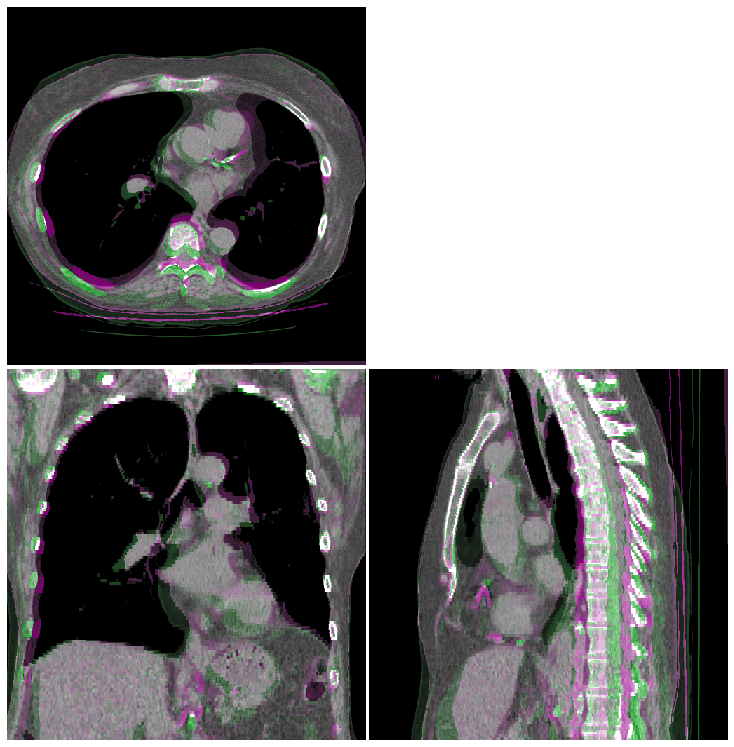

In [10]:
vis = ImageVisualiser(img_ct_lung_5)
vis.add_comparison_overlay(transformed_image)
fig = vis.show()

In [11]:
print(combined_affine)

itk::simple::AffineTransform
 AffineTransform (00000286516DDBD0)
   RTTI typeinfo:   class itk::AffineTransform<double,3>
   Reference Count: 1
   Modified Time: 1139
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.998324 -0.0236429 -0.0528302 
     0.0249252 0.999407 0.023746 
     0.0522375 -0.025023 0.998321 
   Offset: [84.0653, -26.2892, -40.6859]
   Center: [6.25701, 0.00700536, 1733.5]
   Translation: [-7.52656, 15.0305, -43.2695]
   Inverse: 
     0.998324 0.0249252 0.0522375 
     -0.0236429 0.999407 -0.025023 
     -0.0528302 0.023746 0.998321 
   Singular: 0



Check in place to determine if the X*Xt matrices results in a matrix with diagonal 1's.

In [12]:
print('4 by 4 Matrix')
print(overall)

print('3 x 3 Matrix')
A = np.array(overall[:3,:3])
print(A)

print('Transposed 3 x 3 Matrix')
A_T = A.transpose()
print(A_T)

print('Multiplication')
prod = np.dot(A,A_T)
print(prod)


4 by 4 Matrix
[[ 9.98323583e-01 -2.36429329e-02 -5.28302424e-02  8.40653164e+01]
 [ 2.49252130e-02  9.99407254e-01  2.37460451e-02 -2.62892256e+01]
 [ 5.22375013e-02 -2.50230418e-02  9.98321136e-01 -4.06858796e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
3 x 3 Matrix
[[ 0.99832358 -0.02364293 -0.05283024]
 [ 0.02492521  0.99940725  0.02374605]
 [ 0.0522375  -0.02502304  0.99832114]]
Transposed 3 x 3 Matrix
[[ 0.99832358  0.02492521  0.0522375 ]
 [-0.02364293  0.99940725 -0.02502304]
 [-0.05283024  0.02374605  0.99832114]]
Multiplication
[[1.00000000e+00 1.18356324e-19 1.79727290e-18]
 [1.18356324e-19 1.00000000e+00 1.20024168e-18]
 [1.79727290e-18 1.20024168e-18 1.00000000e+00]]


See if it's possible to convert the 4x4 matrix into a AffineTransform object